In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from core.core import * 
from util.detector import * 
from util.estimator import * 
from util.modem import * 

In [3]:
def ml(y_re, H_re, symbol_space, snr_dB):
    """
    Maximum Likelihood detection for KxN mu-MIMO channel (uses Gaussian distribution) 
    """
    # complex to real and then reshape for broadcast
    snr = 10**(snr_dB/20)
    T = H_re.shape[0]
    K = H_re.shape[-1] // 2
    M = int(symbol_space.shape[0] ** (1/K))
    x_shape = tuple([T, K, 1])
    symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))
    likelihood = phi(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
    log_likelihood = np.sum(np.log(likelihood), axis=2)
    x_hat_idx = np.argmax(log_likelihood, axis=1)
    x_hat_ML = np.take(symbol_space, x_hat_idx, axis=0)
    x_hat_ML = x_hat_ML.reshape(x_shape)
    return x_hat_ML 

def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

def initialize(G_tilde, y_re):
    num1 = np.matmul(G_tilde.transpose(0, 2, 1), np.ones_like(y_re))
    denom1 = np.linalg.norm(num1, axis=1).reshape(-1, 1, 1)
    x_init = (num1 / denom1) * np.sqrt(K)
    return x_init


# 1. Maximum Likelihood Detection for 1-bit ADC 

In [15]:
trials = 10
K = 2; N = 16; T = 10000; M = 4

snr_min = -10 
snr_max = 30 
snr_lst = np.arange(snr_min, snr_max+1, 5)

constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

symbol_space = make_symbol_space(K, M, constellation_points)

sers_avg = np.zeros(shape=(len(snr_lst), )) 
x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)

for t in range(trials):
    print(f"Trial #{t}: ", end=' ')
    sers = []
    for snr in snr_lst:
        # print(f"snr {snr}...", end=' ')

        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z  

        # 1-bit ADC 
        y = np.sign(r.real) + 1j * np.sign(r.imag) 

        H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

        x_hat_ML = ml(y_re=y_re, H_re=H_re, symbol_space=symbol_space, snr_dB=snr)

        ser_ml = np.sum(1 - np.isclose(x_hat_ML, x)) / (T * K)
        sers.append(ser_ml)

    sers = np.array(sers)
    print(sers)
    print(sers_avg)
    sers_avg += sers     

sers_avg /= trials
print(sers_avg)

Trial #0:  

/var/folders/qf/g6m74fsx51j_2q1__9zjd_5m0000gn/T/ipykernel_11336/138658605.py:13: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(likelihood), axis=2)


[3.1395e-01 1.0750e-01 1.4650e-02 1.3500e-03 5.0000e-05 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
Trial #1:  [3.162e-01 1.075e-01 1.265e-02 7.500e-04 1.000e-04 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[3.1395e-01 1.0750e-01 1.4650e-02 1.3500e-03 5.0000e-05 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
Trial #2:  [3.117e-01 1.110e-01 1.235e-02 1.000e-03 5.000e-05 0.000e+00 0.000e+00
 0.000e+00 0.000e+00]
[6.3015e-01 2.1500e-01 2.7300e-02 2.1000e-03 1.5000e-04 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
Trial #3:  [3.1500e-01 1.0985e-01 1.3650e-02 9.5000e-04 1.0000e-04 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
[9.4185e-01 3.2600e-01 3.9650e-02 3.1000e-03 2.0000e-04 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00]
Trial #4:  [0.31615 0.1056  0.01345 0.0011  0.      0.      0.      0.      0.     ]
[1.25685e+00 4.35850e-01 5.33000e-02 4.05000e-03 3.00000e-04 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00]
Trial #5:  [3.1785e-01 1.0585e-01 1.3100e-02 1

# 2. Robust ML detection for robust 1-bit ADC 

- Maximum Likelihood method 
- Normal distribution  -->  sigmoid function (softplus)

In [87]:
def sigmoid(t, c=1.702):
    return (1 / (1 + np.exp(-1 * c * t)))

def robust_ml(y_re, H_re, symbol_space, snr_dB):
    """
    robust Maximum Likelihood detection for KxN mu-MIMO channel (uses sigmoid instead of Normal Distribution) 
    """
    # complex to real and then reshape for broadcast
    snr = 10**(snr_dB/20)   # convert dB scale to normal scale 

    # get informations from the channel matrix 
    T = H_re.shape[0]
    K = H_re.shape[-1] // 2
    M = int(symbol_space.shape[0] ** (1/K))
    x_shape = tuple([T, K, 1])

    # real representation of symbol_space 
    symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))

    # Compute the Log-likelihood 
    likelihood = sigmoid(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
    log_likelihood = np.sum(np.log(likelihood), axis=2)

    # pick symbol from the symbol space which maximizes the Likelihood 
    x_hat_idx = np.argmax(log_likelihood, axis=1)
    x_hat_rML = np.take(symbol_space, x_hat_idx, axis=0)
    x_hat_rML = x_hat_rML.reshape(x_shape)
    return x_hat_rML 

In [98]:
trials = 100
K = 2; N = 16; T = 10000; M = 4

snr_min = -10 
snr_max = 30 
snr_lst = np.arange(snr_min, snr_max+1, 5)

constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

symbol_space = make_symbol_space(K, M, constellation_points)

sers_avg = np.zeros(shape=(len(snr_lst), 2)) 
x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)

for t in range(trials):
    print("Trial", t, "...", end=' ')
    sers = []
    for snr in snr_lst:
        # print(f"snr {snr}...", end=' ')

        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z  

        # 1-bit ADC 
        y = np.sign(r.real) + 1j * np.sign(r.imag) 

        H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

        x_hat_ML = ml(y_re, H_re, symbol_space, snr)
        x_hat_rML = robust_ml(y_re=y_re, H_re=H_re, symbol_space=symbol_space, snr_dB=snr)
        ser_ml = np.sum(1 - np.isclose(x_hat_ML, x)) / (T * K)
        ser_rml = np.sum(1 - np.isclose(x_hat_rML, x)) / (T * K)
        # print(ser_rml)
        sers.append([ser_ml, ser_rml])
    sers = np.array(sers)
    print(sers[:, 0])

    sers_avg += sers     

sers_avg /= trials
# print(f"{sers_avg[:, 0]}")
# print(f"{sers_avg[:, 1]}")



Trial 0 ... 

/var/folders/qf/g6m74fsx51j_2q1__9zjd_5m0000gn/T/ipykernel_11336/138658605.py:13: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(likelihood), axis=2)


[3.16645e-01 1.07435e-01 1.39950e-02 8.20000e-04 3.50000e-05 1.00000e-05
 0.00000e+00 5.00000e-06 0.00000e+00]
Trial 1 ... 

KeyboardInterrupt: 

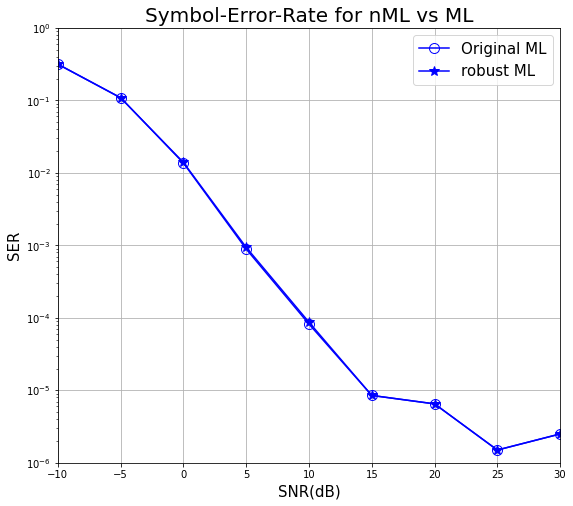

In [95]:
plt.figure(figsize=(9, 8))
# plt.semilogy(snr_lst[1:], results[2], '-s', )
plt.semilogy(snr_lst, sers_avg[:, 0], '-bo', markersize=10, label='Original ML', fillstyle='none')
plt.semilogy(snr_lst, sers_avg[:, 1], '-b*', markersize=10, label='robust ML')
plt.xlim([-10, 30]); plt.ylim([1e-6, 1e0])
plt.xlabel("SNR(dB)", fontsize=15); plt.ylabel("SER", fontsize=15); plt.title("Symbol-Error-Rate for nML vs ML", fontsize=20)
plt.grid(); plt.legend(fontsize=15)
plt.show()

# 3. Robust ML with optimization method

- optimization method 
- can be extended to deep unfolded network that learns learning rates

In [224]:
def sigmoid(t, c=1.702):
    return (1 / (1 + np.exp(-1 * c * t)))

def softplus(t):
    return np.log(1 + np.exp(t))

def robust_ml(y_re, H_re, symbol_space, snr_dB):
    """
    robust Maximum Likelihood detection for KxN mu-MIMO channel (uses sigmoid instead of Normal Distribution) 
    """
    # complex to real and then reshape for broadcast
    snr = 10**(snr_dB/20)   # convert dB scale to normal scale 

    # get informations from the channel matrix 
    T = H_re.shape[0]
    K = H_re.shape[-1] // 2
    M = int(symbol_space.shape[0] ** (1/K))
    x_shape = tuple([T, K, 1])

    # real representation of symbol_space 
    symbol_space_re = np.hstack((symbol_space.real, symbol_space.imag)) * np.ones(shape=(T, M**K, 2*K))

    # Compute the Log-likelihood 
    likelihood = sigmoid(np.matmul(symbol_space_re, H_re.transpose(0, 2, 1)) * y_re.transpose(0, 2, 1) * np.sqrt(2 * snr))
    log_likelihood = np.sum(np.log(likelihood), axis=2)

    # pick symbol from the symbol space which maximizes the Likelihood 
    x_hat_idx = np.argmax(log_likelihood, axis=1)
    x_hat_rML = np.take(symbol_space, x_hat_idx, axis=0)
    x_hat_rML = x_hat_rML.reshape(x_shape)
    return x_hat_rML 

def initialize(G_tilde, y_re):
    num1 = np.matmul(G_tilde.transpose(0, 2, 1), np.ones_like(y_re))
    denom1 = np.linalg.norm(num1, axis=1).reshape(-1, 1, 1)
    x_init = (num1 / denom1) * np.sqrt(K)
    return x_init


def cost(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    g = np.sqrt(2 * snr) * (G_tilde @ x_init) 
    g = softplus(g) 
    g = np.log(g) 
    g = np.sum(g, axis=1) 
    return g

def compute_gradient(G_tilde, x_init, snr):
    c = 1.702
    snr = 10 ** (snr/20) 
    grad = np.sqrt(2 * snr) * np.matmul(G_tilde, x_init)
    grad = sigmoid(-grad)
    grad = np.matmul(G_tilde.transpose(0, 2, 1), grad)
    grad = -1 * c * np.sqrt(2 * snr) * grad
    return grad

def GD(x_init, snr, G_tilde, epoch=100, lr=0.1):
    global K
    costs = []
    for e in range(epoch):
        # print(x_init[0].squeeze(), '-->', end=' ')
        x_init -= lr * compute_gradient(G_tilde=G_tilde, x_init=x_init, snr=snr)
        # print(x_init[0].squeeze())
        if np.linalg.norm(x_init) >= np.sqrt(K):
            x_init /= np.linalg.norm(x_init, axis=1).reshape(-1, 1, 1)
            x_init *= np.sqrt(K)
        costs.append(cost(G_tilde=G_tilde, x_init=x_init, snr=snr))
        # if e % 1 == 0 : 
            # print(f"epoch {e}: descent_r=", np.around(compute_gradient(G_tilde=G_tilde, x_init=x_init, snr=snr).squeeze(), 2))
            # print(f"epoch {e}: descent_c=", np.around(compute_gradient_c(G_tilde=G_tilde, x_init=x_init, snr=snr).squeeze(), 2))
            # print(f"epoch {e}: cost=", np.around(cost(G_tilde=G_tilde, x_init=x_init, snr=snr).squeeze(), 2))
            # print(f"epoch {e}: cost=", np.around(cost_c(G_tilde=G_tilde, x_init=x_init, snr=snr).squeeze(), 2))
    return costs, x_init


def nML_robust(H_re, y_re):
    """
    near maximum likelihood method (first stage)
    """
    global snr
    G_tilde = H_re * y_re 
    x_init = initialize(G_tilde=G_tilde, y_re=y_re)
    _, x_tilde_re = GD(x_init=x_init, snr=snr, epoch=100, lr=0.008, G_tilde=G_tilde)
    x_tilde = x_tilde_re[:, :K, :] + 1j * x_tilde_re[:, K:, :]
    return x_tilde 

In [227]:
trials = 100
K = 4; N = 32; T = 3000; M = 4

snr_min = -10 
snr_max = 30 
snr_lst = np.arange(snr_min, snr_max+1, 5)

constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

symbol_space = make_symbol_space(K, M, constellation_points)

sers_avg = np.zeros(shape=(len(snr_lst), 2)) 
x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
x = np.take(constellation_points, x)



for t in range(trials):
    print(f"Trial #{t}: ", end=' ')
    sers = []
    for snr in snr_lst:
        # print(f"snr {snr}...", end=' ')

        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z  

        # 1-bit ADC 
        y = np.sign(r.real) + 1j * np.sign(r.imag) 

        H_re, x_re, z_re, y_re = comp2re(H, x, z, y)

        # near ML estimation(functional)
        G_tilde = H_re * y_re 
        x_init = initialize(G_tilde=G_tilde, y_re=y_re) 
        # x_init_c = x_init[:, :K, :] + 1j * x_init[:, K:, :]
        x_tilde = nML_robust(H_re, y_re)
        x_det_first_stage = symbol_by_symbol(x_tilde=x_tilde, constellation_points=constellation_points)
        # x_det = symbol_by_symbol(x_tilde=x_init_c, constellation_points=constellation_points)
        x_hat_ML = ml(y_re=y_re, H_re=H_re, symbol_space=symbol_space, snr_dB=snr)


        ser = np.sum(1 - np.isclose(x_det_first_stage, x)) / (T * K)
        # ser_init = np.sum(1 - np.isclose(x_det, x)) / (T * K)
        ser_ml = np.sum(1 - np.isclose(x_hat_ML, x)) / (T * K)

        sers.append([ser, ser_ml])

    sers = np.array(sers)
    print("SER per snr:  \n   ", sers[:, 0].squeeze())
    print(sers[:, 1].squeeze())
    # print(sers[:, 2].squeeze())
    sers_avg += sers     

sers_avg /= trials

plt.plot(snr_lst, sers[:, 0])

Trial #0:  

/var/folders/qf/g6m74fsx51j_2q1__9zjd_5m0000gn/T/ipykernel_11336/138658605.py:13: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(likelihood), axis=2)


SER per snr:  
    [0.19891667 0.04525    0.00341667 0.00025    0.         0.
 0.         0.         0.        ]
[0.19275    0.03741667 0.00233333 0.         0.         0.
 0.         0.         0.        ]
Trial #1:  SER per snr:  
    [2.04083333e-01 4.65000000e-02 5.00000000e-03 3.33333333e-04
 0.00000000e+00 8.33333333e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[1.99083333e-01 3.59166667e-02 2.00000000e-03 8.33333333e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Trial #2:  SER per snr:  
    [2.03750000e-01 4.19166667e-02 5.58333333e-03 3.33333333e-04
 1.66666667e-04 8.33333333e-05 0.00000000e+00 0.00000000e+00
 2.50000000e-04]
[1.98833333e-01 3.28333333e-02 2.75000000e-03 8.33333333e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Trial #3:  SER per snr:  
    [2.06916667e-01 4.61666667e-02 4.66666667e-03 3.33333333e-04
 1.66666667e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.66666667e-04]
[2.00333

KeyboardInterrupt: 

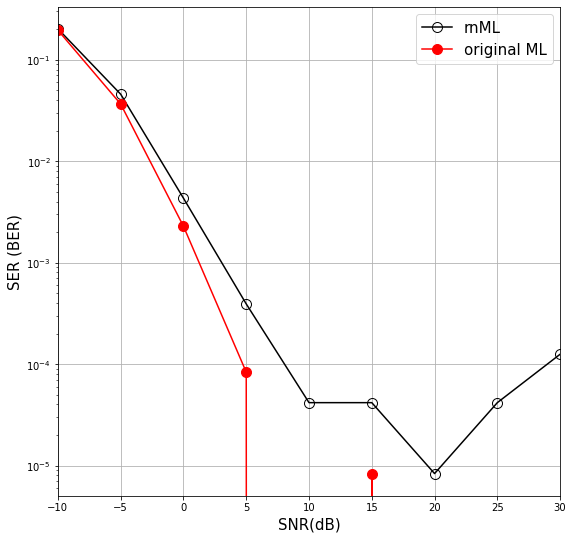

In [226]:

plt.figure(figsize=(9, 9))
plt.semilogy(snr_lst, sers_avg[:, 0], '-ko', fillstyle='none', markersize=10, label='rnML')
plt.semilogy(snr_lst, sers_avg[:, 1], '-ro', markersize=10, label='original ML')
plt.xlabel("SNR(dB)", fontsize=15)
plt.ylabel("SER (BER)",fontsize=15)
plt.xlim([-10, 30])
plt.legend(fontsize=15); plt.grid()
plt.show()

In [192]:
def cost(G_tilde, x_init, snr):
    snr = 10 ** (snr/20) 
    g = -1.702 * np.sqrt(2 * snr) * (G_tilde @ x_init) 
    g = softplus(g) 
    # g = np.log(g) 
    # g = np.sum(g, axis=1)
    g = np.sum(g) 
    return g

def compute_gradient(G_tilde, x_init, snr):
    c = 1.702
    snr = 10 ** (snr/20) 
    grad = np.sqrt(2 * snr) * np.matmul(G_tilde, x_init)
    grad = sigmoid(-grad)
    grad = np.matmul(G_tilde.T, grad)
    grad = -1 * c * np.sqrt(2 * snr) * grad
    return grad



In [199]:
import tensorflow as tf 
from tensorflow.keras.activations import softplus

def loss_fn(G, X, snr):
    snr = 10 ** (snr/20)
    return tf.reduce_sum(tf.math.softplus(-1.702 * np.sqrt(2*snr) * tf.matmul(G, X)))

X = tf.constant(x_init[0])
G = G_tilde[0]
snr = 30

with tf.GradientTape() as g:
    g.watch(X)
    cost = loss_fn(G, X, snr)
grad = g.gradient(cost, X)
print(grad)


grad_compare = compute_gradient(G_tilde[0], x_init[0], snr=snr)

np.isclose(grad.numpy(), grad_compare)




tf.Tensor(
[[-13.07742762]
 [-30.47469446]
 [-30.29841368]
 [  5.23452352]], shape=(4, 1), dtype=float64)


array([[ True],
       [ True],
       [ True],
       [ True]])

In [174]:
G == np.diag(y_re[0].squeeze()) @ H_re[0] 

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
 

In [136]:
import tensorflow as tf

from tensorflow.keras.activations import softplus as sp 

In [141]:
X = tf.constant(x_init[0])
G = G_tilde[0]
snr = 10 ** (5/20)
tf.reduce_sum(sp(1.702 * np.sqrt(2 * snr) * tf.matmul(G, X))), cost(G, x_init[0], snr=5)

(<tf.Tensor: shape=(), dtype=float64, numpy=90.37423336189283>,
 90.37423336189283)

In [142]:
def loss_fn(G, X, snr):
    snr = 10 ** (snr/20)
    return tf.reduce_sum(tf.math.softplus(1.702 * np.sqrt(2*snr) * tf.matmul(G, X)))